In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image
from pathlib import Path
from sklearn.mixture import GaussianMixture
import os

In [2]:
def check_jpg_counts(path):
    cnt = 0
    for dir_name in os.listdir(path):
        dir_path = os.path.join(path, dir_name)
        if os.path.isdir(dir_path):
            jpg_count = sum(1 for f in os.listdir(dir_path) if f.endswith(".jpg"))
            if jpg_count != 170:
                print(f"file {dir_name} has {jpg_count} number .jpg")
            cnt += jpg_count
    print('other files each 170 number .jpg')
    print(f"total {cnt} number .jpg")


# check the number of .jpg files in each directory
_dataset_dir = "./data/PIE"
check_jpg_counts(_dataset_dir)

file 38 has 164 number .jpg
other files each 170 number .jpg
total 11554 number .jpg


In [3]:
test_tfm = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # change own image to 1 channel
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])


class FaceDataset(Dataset):

    def __init__(self, path, tfm=test_tfm, files=None):
        super(FaceDataset, self).__init__()
        self.path = path
        self.files = self._get_all_files(path) if files is None else files
        if len(self.files) == 0:
            raise ValueError(f"No .jpg files found in {path}")
        print(f"One {path} sample", self.files[0])
        self.transform = tfm

    def _get_all_files(self, path):
        """Recursively get all jpg files."""
        file_list = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.jpg'):
                    file_list.append(os.path.join(root, file))
        return sorted(file_list)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        im = Image.open(fname)
        if self.transform:
            im = self.transform(im)
        try:
            label = int(fname.split("/")[-2])  # adjusted to get the parent directory as label
        except:
            label = -1  # test has no label
        return im, label


In [4]:
seed = 202311172359
num_subject = 25
subjects_index = np.random.default_rng(seed).choice(np.arange(1, 69), num_subject, replace=False)

image_data = []
label_data = []

directory = Path("../ca2/data/PIE")
for i in subjects_index:
    images_folder = []
    labels_folder = []
    sub_file = directory / str(i)

    files = list(sub_file.glob("*.jpg"))
    np.random.default_rng(seed).shuffle(files)
    for filename in files:
        image0 = Image.open(filename)
        images_folder.append(np.array(image0))
        labels_folder.append(i)
    image_data.append(images_folder)
    label_data.append(labels_folder)

print(subjects_index)

[18 46 32 42  6 15 33 64 23 39  7 54 53 28 58 11  3 17 52  2 67 49 20 66
 50]


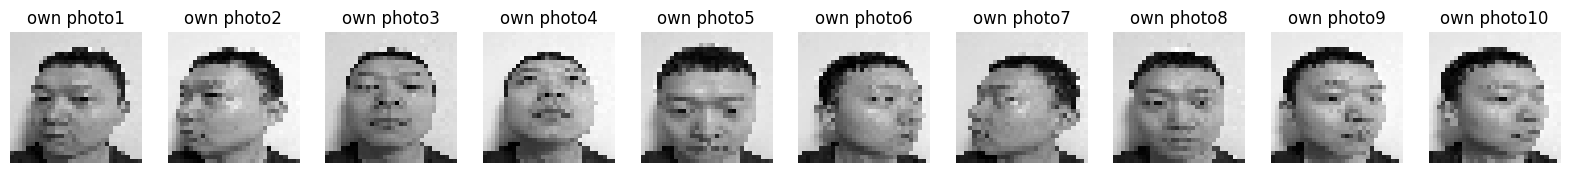

In [5]:
own_image_data = []
own_label_data = []

for i in range(1, 10 + 1):
    img = cv.imread('../ca2/data/own/69/' + str(i) + '.jpg', cv.IMREAD_GRAYSCALE)
    img = cv.resize(img, (32, 32), interpolation=cv.INTER_CUBIC)
    own_image_data.append(img)
    own_label_data.append(69)

# train, test split, rate 7:3
own_train_image_data = own_image_data[0:7]
own_test_image_data = own_image_data[7:]
own_train_label_data = own_label_data[0:7]
own_test_label_data = own_label_data[7:]

fig = plt.figure(figsize=(20, 10))

for i in range(1, 11):
    plt.subplot(1, 10, i)
    plt.imshow(own_image_data[i - 1], cmap='gray')
    plt.title('own photo' + str(i))
    plt.axis('off')

plt.show()

In [6]:
# split train and test data
NUM_TRAIN_IMAGES_PER_SUBJECT = np.int_(np.around(0.7 * 170))

image_data_train, image_data_test = np.split(np.array(image_data), [NUM_TRAIN_IMAGES_PER_SUBJECT], axis=1)
label_data_train, label_data_test = np.split(np.array(label_data), [NUM_TRAIN_IMAGES_PER_SUBJECT], axis=1)
own_image_data_train, own_image_data_test = np.split(np.array(own_image_data), [7])
own_label_data_train, own_labels_data_test = np.split(np.array(own_label_data), [7])

import warnings
# ignore warnings for this part
warnings.filterwarnings('ignore', category=Warning)

# reshape data
main_image_data_train = image_data_train.reshape(num_subject * NUM_TRAIN_IMAGES_PER_SUBJECT, 1024)
own_image_data_train = own_image_data_train.reshape(7, 1024)
image_data_test = image_data_test.reshape(num_subject * (170 - NUM_TRAIN_IMAGES_PER_SUBJECT), 1024)
own_image_data_test = own_image_data_test.reshape(3, 1024)

label_data_train = label_data_train.reshape(num_subject * NUM_TRAIN_IMAGES_PER_SUBJECT)
label_data_test = label_data_test.reshape(num_subject * (170 - NUM_TRAIN_IMAGES_PER_SUBJECT))

# Combine PIE images and own photos to get full train and test sets
full_train_image_set = np.append(main_image_data_train, own_image_data_train, axis=0, )
full_train_label_set = np.append(label_data_train, own_label_data_train)

full_test_image_set = np.append(image_data_test, own_image_data_test, axis=0, )
full_test_label_set = np.append(label_data_test, own_labels_data_test)

In [7]:
# full data set
X_train = full_train_image_set
y_train = full_train_label_set

In [8]:
def GMM_operator(X, d):  # X is dataset and d is dimesion of data
    gmm = GaussianMixture(n_components=3).fit(X)
    pred_y = gmm.predict(X)

    fig = plt.figure()
    ax = fig.add_subplot(8, 10, (41, 80))
    for i in range(3):
        ax.scatter(X[pred_y == i][:, 0], X[pred_y == i][:, 1], label=i, )

    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.title.set_text('Clustering results for data in %d dimension' % d)
    ax.legend()

    for i in range(3):
        for j in range(10):
            faces = fig.add_subplot(8, 10, i * 10 + j + 1)
            faces.set_axis_off()
            faces.imshow(X_train[pred_y == i][j * 15].reshape(32, 32), cmap="gray")

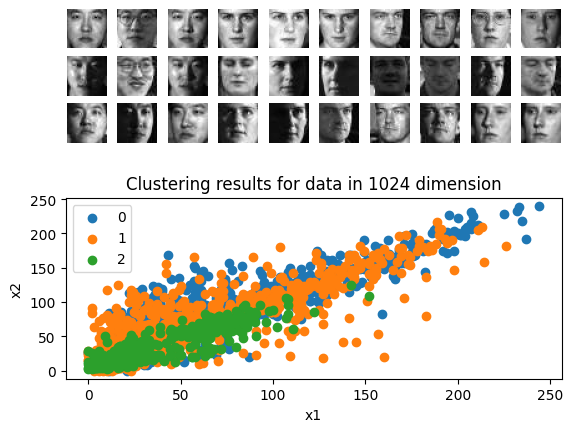

In [9]:
GMM_operator(X_train, 32 * 32)

In [10]:
X_mean = np.mean(X_train, axis=0)
X_norm = X_train - X_mean

u, s, vt = np.linalg.svd(X_norm, full_matrices=False)
s_diag = np.diag(s)

X_pca = u[:, :200] @ s_diag[:200, :200]

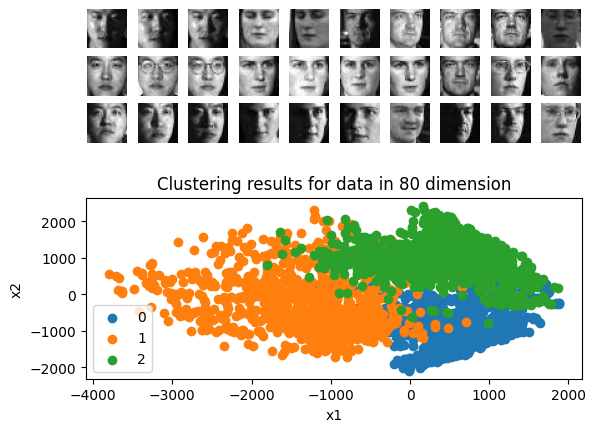

In [11]:
GMM_operator(X_pca[:, :80], 80)

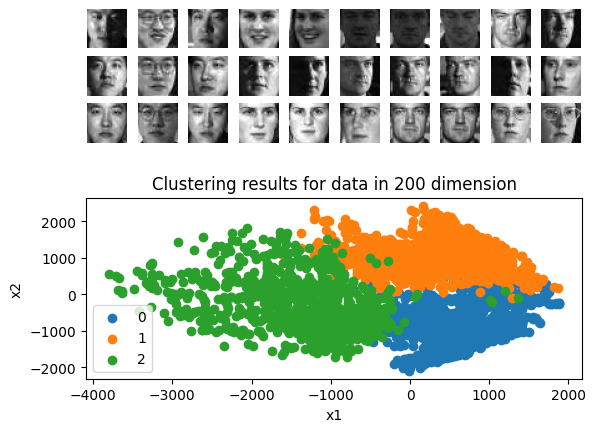

In [12]:
GMM_operator(X_pca[:, :200], 200)